# Affine transformations testing


In [1]:
import torch
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
## Create a custom dataset class to hold our weird data samples


In [3]:
class SiameseDataset(data.Dataset):
    """Dataset that reads the data from an npy file and 
    returns a pair to the loader"""
    def __init__(self, data_path=None, labels_path=None, 
                 transform=None, dataset: data.Dataset =None, 
                 data : np.ndarray = None, labels: np.ndarray = None,
                 mean : float = None, std : float = None,
                 transform_data=False):
        self.transform_data = transform_data
        # If we're given another dataset, just take that
        if dataset is not None:
            self.data = dataset.data
            self.labels = dataset.labels
            self.transforms = dataset.transforms
        # We can also pass the data and labels as an array
        elif data is not None:
            self.data = data
            self.labels = labels
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
            ])
        # If not, that means that we load it from a file
        else:
            # Load the data and labels
            self.data = np.load(data_path)
            self.labels = np.load(labels_path)

            # for training set, calculate mean and std
            # to normalize
            if mean == None and std == None:
                # stats of the dataset
                self.mean = np.mean(self.data[:,:,:])
                self.std = np.std(self.data[:,:,:])
            # for test set, use mean and std from
            # the train set to normalize
            else:
                self.mean = mean
                self.std = std
            # Normalize by default!
            self.normalize = transforms.Normalize(mean=(self.mean,),
                                                std = (self.std,))
            # We apply the transformations that are given, so we can 
            # join the datasets
            self.transforms = transforms.Compose([
                transform, 
                transforms.ToTensor(),
            ])
            
    def __len__(self):
        return len(self.data)
    
    def get_images(self, index):
        _x1 = self.data[index,0,:,:]
        _x2 = self.data[index,1,:,:]
        label = self.labels[index]
        return Image.fromarray(_x1), Image.fromarray(_x2), label
        
    
    def __getitem__(self, index):
        """ Gets the next pair from 
        the dataset and its corresponding label
        (0 or 1 depending on if they're the same
        or a different letter)"""
        _x1 = self.data[index,0,:,:]
        _x2 = self.data[index,1,:,:]
        label = self.labels[index]
        
        # Convert to PIL Images so 
        # we can transform them with affine transforms
        # Just needed to generate the dataset
        if self.transform_data:
            _x1 = Image.fromarray(_x1)
            _x2 = Image.fromarray(_x2)
            
            # we need to convert the x's to images to apply the transforms
            return self.transforms(_x1), self.transforms(_x2), label
        else:
            return _x1, _x2, label
    
    
def show_pair(x1, x2, lab):
    """Function to show two images of the dataset side by side"""
    # x1 = x1.numpy()
    # x2 = x2.numpy()
    f ,(ax1, ax2) = plt.subplots(1, 2, sharey= True)
    ax1.imshow(x1.squeeze())
    ax2.imshow(x2.squeeze())
    plt.show()
    print('same' if lab == 1 else 'different')
    
def show_image_pair(i1, i2, lab):
    f ,(ax1, ax2) = plt.subplots(1, 2, sharey= True)
    ax1.imshow(i1)
    ax2.imshow(i2)
    plt.show()
    print('same' if lab == 1 else 'different')
    
    

## Declare the transformations and load the data into the dataset

**IMPORTANT** For the first run generating the data you want to set `transform_data` to 
True so that the affine transformations are randomly applied to generate the other datasets.
But once those datasets are generated and saved, you want to set that to False so that the
images that the dataset returns are deterministic
    

In [8]:
# Affine transformations to be done on the data
affine = transforms.RandomAffine(degrees = (-10,10), 
                                 translate=(0.2,0.2),
                                 scale = (0.8, 1.2),
                                 shear = (-0.3, 0.3), 
                                 fillcolor=255)


# define the paths of the data
data_path = "data/processed/trainX_30k.npy"
labels_path = "data/processed/trainY_30k.npy"

# Try to represent the images

d = SiameseDataset(data_path, labels_path, transform=affine, transform_data=True)


### You can run the code below as many times as you want to see examples of images
The percentage of same/different pairs should be around 50%


## Apply transformations to the dataset

Each image in the dataset should be transformed randomly with 4 different transformations, and do that 8 times.
We do this by applying a random affine transformation 

- Degrees [-10, 10]
- Translate [-2,2]
- Scale [0.8,1.2]
- Shear [-0.3, 0.3]

First read all the data and iterate through it while saving it to another dataset

In [9]:
import gc
import pickle

gc.collect()

# Path to which we'll save the data augmented
save_path = "data/augmented/30k/"

# Create a data loader of the dataset
loader = data.DataLoader(d, batch_size=15000)

_altered = None
# Check the size of the batches and so on
# Read in batches of 512, and do it 
for j in range(8):
    gc.collect()
    _altered = None
    print("starting with round ",j)
    for i, (x1, x2, _) in enumerate(loader):
        if i % 1 == 0:
            print(i)
        # concatenate the arrays by their second axis
        _data = np.concatenate((x1.numpy().astype(np.uint8), x2.numpy().astype(np.uint8)), axis = 1)
        # add them to the dataset
        if _altered is None:
            _altered = _data
        else:
            # Concatenate the existing data and the new batch
            _altered = np.concatenate((_altered, _data), axis = 0)
    
    print("Saving dataset ",j)
    with open(f'{save_path}{j}.npy', 'wb') as f:
        np.save(f, _altered)
    del _altered


starting with round  0
0
1
Saving dataset  0
starting with round  1
0
1
Saving dataset  1
starting with round  2
0
1
Saving dataset  2
starting with round  3
0
1
Saving dataset  3
starting with round  4
0
1
Saving dataset  4
starting with round  5
0
1
Saving dataset  5
starting with round  6
0
1
Saving dataset  6
starting with round  7
0
1
Saving dataset  7


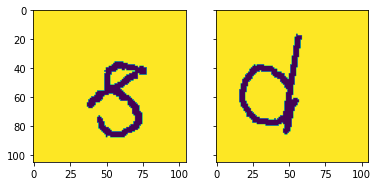

different
different


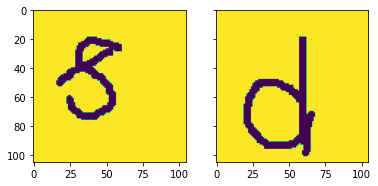

In [20]:
a, b, l2 = d.__getitem__(2)
c, h, l = d.__getitem__(60002)

show_pair(c, h, l)
show_pair(a, b, l2)

## Now combine the datasets that are stored in the folder

We then have a dataset of length 270.000 in case of the 30k train dataset.

The labels are the same for all the datasets cause we did not shuffle, therefore we can reuse
those of the original dataset.

Once we want to train the network, we want to shuffle with the dataloader we wrap this ConcatDataset with

In [14]:
save_path = "data/augmented/30k/"
# Do for each of the files
# We'll use the same labels cause the order is the same
labels = d.labels
for i in range(8):
    print('Opening dataset', i)
    _d = np.load(f'{save_path}{i}.npy')
    _sd = SiameseDataset(data = _d, labels = labels)
    d = data.ConcatDataset((d, _sd))
    print('concated')





Opening dataset 0
concated
Opening dataset 1
concated
Opening dataset 2
concated
Opening dataset 3
concated
Opening dataset 4
concated
Opening dataset 5
concated
Opening dataset 6
concated
Opening dataset 7
concated
